In [1]:
# Some functions to define for better notebook usability
import matplotlib.pyplot as plt
import numpy as np
def plot_target_distribution(data):
    plt.figure(figsize=(8, 4))  # Set the figure size (optional)
    plt.hist(data, bins=18)  # Adjust the number of bins as needed

    # Add labels and a title
    plt.xlabel('Delay')
    plt.ylabel('Frequency')
    plt.title('Distribution of the Delay (minutes)')

    # Display the plot
    plt.grid(True)  # Add grid lines (optional)
    plt.show()

def plot_fi(fi_r, fi_c):
    keys1, values1 = zip(*fi_r)
    keys2, values2 = zip(*fi_c)

    # Plot feature importance
    # Create a bar plot with two sets of bars
    width = 0.35  # Width of each bar
    x = np.arange(len(keys1))  # x-positions for the bars

    # Create subplots for two sets of bars
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the first set of bars
    rects1 = ax.bar(x - width/2, values1, width, label='Regression Importance', color='blue')

    # Plot the second set of bars
    rects2 = ax.bar(x + width/2, values2, width, label='Classification Importance', color='red')

    # Add labels and a legend
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title('Feature Importance')
    ax.set_xticks(x)
    ax.set_xticklabels(keys1)
    ax.legend()

    # Display the plot
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.grid(axis='y')  # Add grid lines along the y-axis (optional)
    plt.tight_layout()  # Ensure labels are fully displayed
    plt.show()

## Data Analysis


### Prepare data

- Reads the data from the provided CSV.
- Computes Synthetic Features.


In [2]:
# load dataset
from latam.dataset import Dataset
from latam.model import Model

ds = Dataset(dataset_file="../latam-layer/latam/data/dataset.csv")
ds.clean()

/Users/andresperez/GitHub/AndresPrez/latam-challenge/app/latam-layer/latam/dataset.py:127: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  self.dataset = pd.read_csv(dataset_file)


### Anomaly Detection

Compute the Median Absolute Deviation (MAD) for the target variable in the dataset. Then we will use the MAD to compute the anomaly score for each observation in the dataset. The anomaly score is the sum of the absolute values of the difference between the observation and the median divided by the MAD. The higher the score, the more anomalous the observation is.


##### Delay Distribution

In [3]:
from scipy.stats import skew, kurtosis
Y = ds.dataset['Diferencia en minutos'].values
y_skew = skew(Y)
y_kurtosis = kurtosis(Y)
print(f"Skew: {y_skew}")
print(f"Kurtosis: {y_kurtosis}")

Skew: 3.553891267526146
Kurtosis: 16.812570822579897


The datapoints seem to have a normal distribution aspect, however its Skew and Kurtosis is considerable high, which suggests that we could perform an anomaly removal, to be better fit for training.

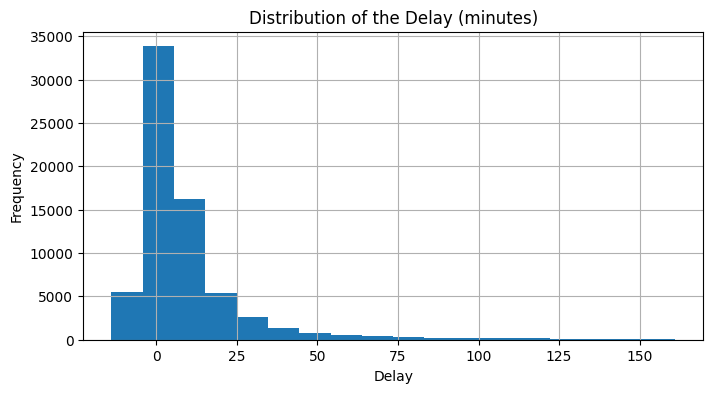

In [4]:
plot_target_distribution(Y)

##### Outliers

Proceed to compute the Robust Z-Score and Z-Score anomaly scores, the former being more robust to outliers as it is less influenced by the distribution's mean and stndard deviation.

We can see from the plot that the Robust Z-Score gives higher weights to outliers. And indeed, it is used as a score that is less influenced by outliers.

Choosing a value of '4' for the Robust Z-Score seems reasonable and reduces the dataset by about 5%.

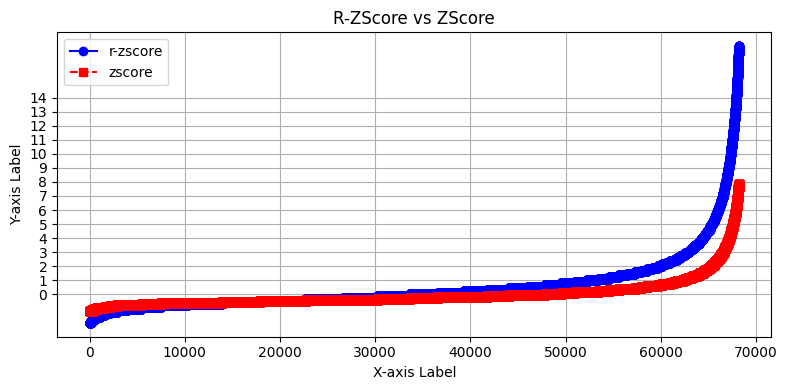

In [5]:
new_X = ds.compute_anomaly_scores(ds.dataset)
rzscore = sorted(new_X['r-zscore'].values)
zscore = sorted(new_X['zscore'].values)

def plot():
    # Create a line plot for the first series
    plt.figure(figsize=(8, 4))  # Set the figure size (optional)
    plt.plot(rzscore, marker='o', linestyle='-', color='blue', label='r-zscore')

    # Create a line plot for the second series
    plt.plot(zscore, marker='s', linestyle='--', color='red', label='zscore')

    # Add labels, a title, and a legend
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label')
    plt.title('R-ZScore vs ZScore')
    plt.legend()

    # Specify Y-axis tick values with more granularity
    plt.yticks(np.arange(0, 15, 1))  # Adjust the tick range and step size as needed

    # Display the plot
    plt.grid(True)  # Add grid lines (optional)
    plt.tight_layout()  # Ensure labels are fully displayed
    plt.show()

plot()

#### Remove outliers
With about 5% of the dataset removed due to detected outliers, the target distribution looks much more normalized with skew and kurtosis values well within acceptable ranges.

Reduced dataset by 5.582% after removing outliers
Skew: 1.1099598605628254
Kurtosis: 1.2637330226551988


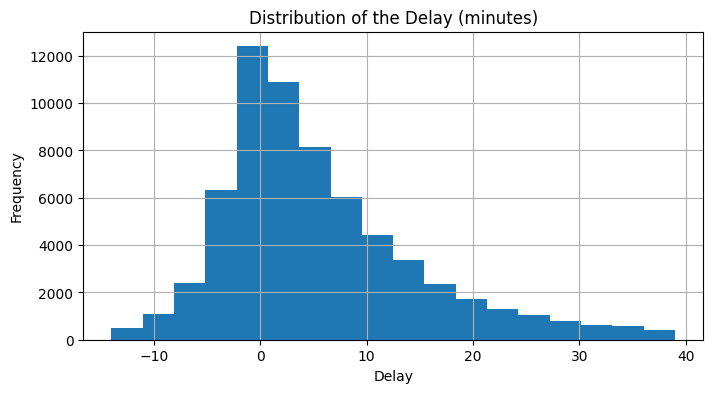

In [6]:
ds.remove_anomalies(threshold=4)
# Let's plot the data distribution once again, but now with the outliers removed
Y = ds.dataset['Diferencia en minutos'].values
y_skew = skew(Y)
y_kurtosis = kurtosis(Y)
print(f"Skew: {y_skew}")
print(f"Kurtosis: {y_kurtosis}")
plot_target_distribution(Y)

### Categorical Data
Analyze the categorical features:
- Count the categories in each feature.
- Compute the average target value for each category.

In [7]:
categoric_cols = ds.get_categoric_features()
categoric_cols.describe()

,Vlo-I,Ori-I,Des-I,Emp-I,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,Periodo día
count,64399,64399,64399,64399,64399,64399,64399,64399,64399
unique,723,1,61,30,2,23,1,60,3
top,174,SCEL,SCFA,LAN,N,Grupo LATAM,Santiago,Buenos Aires,mañana
freq,660,64399,5562,35901,35403,38913,64399,5867,24231


### Encode Data

- Encode categorical features using target encoding: which a technique to reduce the number of categories. It converts each category to the average target value for that same category.
- Encode date features using cyclic encoding: which is a technique that better represents the cyclical nature of dates.

In [8]:
if ds.encoded_dataset is None: ds.encode(encoding_file="../latam-layer/latam/data/categorical_encoder.pickle")

Categorical encodings loaded from ../latam-layer/latam/data/categorical_encoder.pickle


### Feature Importance/Selection

In order to reduce the complexity of the dataset, we can choose to compute the feature importance of each variable. This will allow us to remove variables that are not important to the model. We will use the XGboost to compute the feature importance.


/Users/andresperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/andresperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/andresperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/andresperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstanc

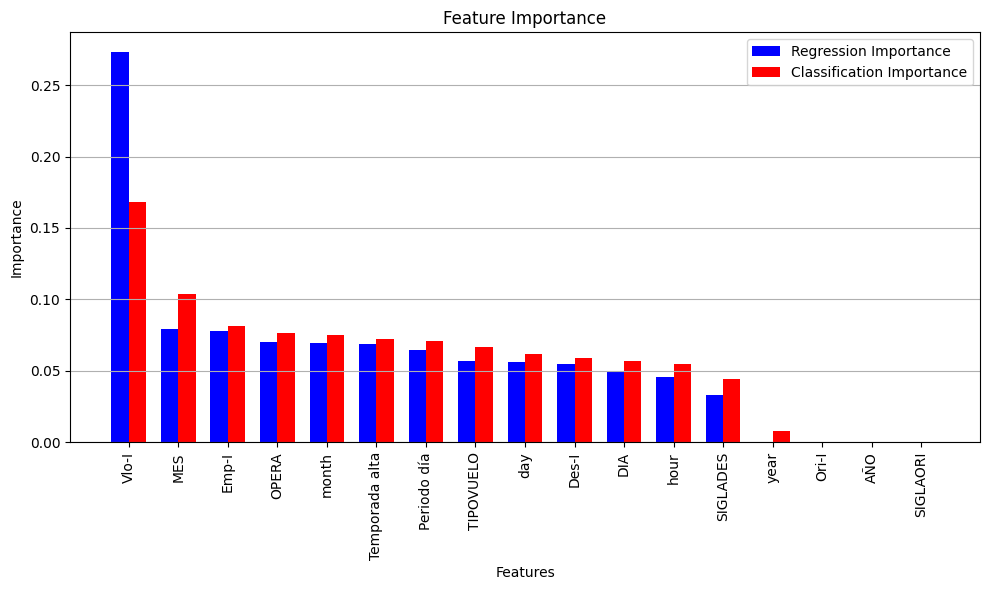

In [9]:
# Regression
Xr, Yr = ds.split_target(for_regression=True)
model_r = Model()
model_r.load_dataset(Xr, Yr)
model_r.fit()
fi_r = model_r.feature_importance()

# Classification
Xc, Yc = ds.split_target(for_regression=False)
model_c = Model()
model_c.load_dataset(Xc, Yc)
model_c.fit()
fi_c = model_c.feature_importance()

plot_fi(fi_r=fi_r, fi_c=fi_c)

It is worth noting that the most important features for both Classifcation and Regression are pretty much the same ones, being 'Vlo-I' the one explaining a lot more of the variance than its peer features. However for classification, 'Vlo-I' loses some importance compared to regression. A possible explanation of this is that when the model tries to fit for regression, the "minor delays" (e.g., under 15 minutes) become more important as they contribute to the loss, but in classification they are all grouped under the "Not Delayed" class, which might make the information in 'Vlo-I' less important.

### Model Training
Use XGBoost to train the model as a Classification problem to detect major delays (those above 15 minutes).
Run Cross-Validation with the complete set of datapoints (the xgboost library will handle data the splitting) to obtain a sense of the model's performance. Additionally 
we can now fit our model and save it for new data to come.

In [12]:
X, Y = ds.split_target(for_regression=False)
model_c = Model()
model_c.load_dataset(X, Y)
# # We then fit the model, and we save it.
model_c.fit()
model_c.save(path="../latam-layer/latam/data/model.bin")
# XGBoost's cross-validation method will handle the train and test set splits for us.
model_c.cv()

/Users/andresperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/andresperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/andresperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/andresperez/.pyenv/versions/3.10.13/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstanc

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.692566,0.000002,0.692586,0.000002
1,0.691987,0.000004,0.692025,0.000004
2,0.691409,0.000006,0.691466,0.000006
3,0.690832,0.000008,0.690908,0.000008
4,0.690256,0.000010,0.690351,0.000010
5,0.689681,0.000012,0.689795,0.000012
6,0.689107,0.000014,0.689241,0.000014
7,0.688535,0.000015,0.688687,0.000015
8,0.687963,0.000017,0.688135,0.000017
9,0.687393,0.000019,0.687583,0.000019


### The model's performance according to XGBoost's Cross-Validation has an accuracy of ~70%.